`
Kyle Johnson
gkj2106
Bayesian Statistics: STAT GR5224
hw 4
`

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
from scipy.stats import beta as scipy_beta, gamma, binom, norm
from scipy.special import beta as beta_f
from scipy.misc import factorial, comb

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 6, 4

# 1.

Capture-recapture: A statistician/fisherman is interested in $N$, the number of fish in a certain pond. He catches 100 fish, tags them, and throws them back. A few days later, he returns and catches fish until he has caught 20 tagged fish, at which point he notes the number of untagged fish he has caught. Assume that all fish are sampled independently and with equal probability.

### a) 
Letting $y$ denote the number of untagged fish caught before the 20th tagged fish, find the likelihood $p(y|N)$.

$p(y|N) \propto p(y = 20 | N)$, $N >= 170$ as we know the fisherman caught 70 untagged and tagged 100 himself.

### b)
Assign the noninformative prior

<center>$p(N) \propto 1 \text{ for } N = 100,101,...$</center>

and suppose the fisherman caught $y = 70$ untagged fish.

i) Verify that the resulting posterior distribution is proper.

Plot $p(N|y)$ over a range of N that includes essentially all of the posterior probability.

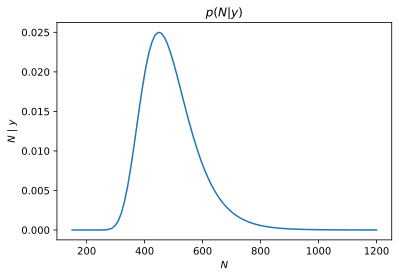

In [2]:
def neg_hyper_geom(N, M, m, k):
    '''
    computes negative hypergeometric, still vectorized
    '''
    a = comb(k + m - 1, k) * comb(N - m - k, M - m)
    b = comb(N, M)
    
    return a / b

domain = np.linspace(150, 1200, 100)
x = neg_hyper_geom(N=domain, M=100, k=70, m=20)

# plot the distribution of N | y assuming a non-informative prior
plt.plot(domain, x)
plt.xlabel(r'$N$')
plt.ylabel(r'$N\ |\ y$')
plt.title(r'$p(N | y)$')
plt.show()

ii) Compute the probability that the next fish caught by the fisherman is tagged.

In [3]:
x_proper = x / x.sum()   # normalize the probabilities of each N
p_tagged_dist = 100 / domain   # basically 100 / N for all N's
p_next_tagged = x_proper @ p_tagged_dist   # integrating out N's 

print('Pr(tagged|y) = {:.3}'.format(p_next_tagged))

Pr(tagged|y) = 0.212


# 2.

Recall the `meta.txt` data, where $y_j$ is the observed treatment effect in the $j$th clinical trial of beta-blockers for heart attack patients. Return to the meta-analysis you conducted for your previous homework assignments.

In [5]:
df = pd.read_csv('data/meta.csv')
df['control_deaths_p'] = (df.treated_deaths / df.treated_total).values
df['treat_deaths_p'] = (df.control_deaths / df.control_total).values
df[['control_deaths', 'control_total', 'treated_deaths', 'treated_total']]

,control_deaths,control_total,treated_deaths,treated_total
0,3,39,3,38
1,14,116,7,114
2,11,93,5,69
3,127,1520,102,1533
4,27,365,28,355
5,6,52,4,59
6,152,939,98,945
7,48,471,60,632
8,37,282,25,278
9,188,1921,138,1916


In [6]:
def odds_ratio(y_1, n_1, y_0, n_0):
    return np.log(y_1 / (n_1 - y_1)) - np.log(y_0 / (n_0 - y_0))

def sample_variance(y_1, n_1, y_0, n_0): 
    return (1. / y_1) + (1. / (n_1 - y_1)) + \
           (1. / y_0) + (1. / (n_0 - y_0))
    
y_1 = df['treated_deaths'].values
n_1 = df['treated_total'].values
y_0 = df['control_deaths'].values
n_0 = df['control_total'].values

# compute odds ratios 
y = odds_ratio(y_1, n_1, y_0, n_0)
sigma_2 = sample_variance(y_1, n_1, y_0, n_0)

### a) 

To test the fit of the model, simulate 1000 random samples from

<center>$p(y^{rep} | y) = \int p(y^{rep}|\theta) p(\theta | y) d\theta$</center>

and examine posterior predictive distributions of the following four test statistics: the smallest (which in this problem means most beneficial) observed effect, $\text{min}_j y_j$, the greatest (least beneficial) observed effect, $\text{max}_j y_j$, the average, mean($y_j$), and the sample standard deviation, sd($y_j$). Compute the p-value for each posterior predictive check.

In [7]:
def odds_ratio(y_1, n_1, y_0, n_0):
    return np.log(y_1 / (n_1 - y_1)) - np.log(y_0 / (n_0 - y_0))

def sample_variance(y_1, n_1, y_0, n_0):
    return (1. / y_1) + (1. / (n_1 - y_1)) + \
           (1. / y_0) + (1. / (n_0 - y_0))

def compute_log_posterior(tau, y, sigma_2):
    V = 1. / np.sum(1. / (sigma_2 + tau**2))
    mu_hat =  V * np.sum(y / (sigma_2 + tau**2))    
    log_post = (np.log(V) - np.sum(np.log(sigma_2 + tau**2))) / 2.
    log_post -= 0.5 * np.sum((y - mu_hat)**2 / (sigma_2 + tau**2))
        
    return log_post

def sample_posterior(n=1000):
    
    # get p(tau | y)
    tau_range = np.linspace(0, .6, 100)
    tau_posterior = np.empty_like(tau_range)
    for i, tau_star in enumerate(tau_range):
        tau_posterior[i] = compute_log_posterior(tau_star, y, sigma_2)
    tau_posterior = np.exp(tau_posterior)   # take exponent and normalize
    tau_posterior = tau_posterior / tau_posterior.sum()
    
    samples = []
    
    for i in range(n):
        # multi-level approach, sample from p(tau | y)
        tau = np.random.choice(tau_range, p=tau_posterior)
        tau += .0000001   # because tau=0 is bad
    
        # sample p(mu | tau, y)
        V_mu = 1. / np.sum(1. / (sigma_2 + tau**2))
        
        mu_hat = V_mu * np.sum(y / (sigma_2 + tau**2))
        mu_sim = np.random.normal(mu_hat, np.sqrt(V_mu))
    
        # sample p(theta | mu, tau, y)
        V = 1. / (1. / sigma_2 + 1./tau**2)
        theta_hat = V * (y / sigma_2 + mu_sim / tau**2)
        theta_sim = np.random.normal(theta_hat, np.sqrt(V))
        
        # sample p(y^{rep} | y)
        samples.append(np.random.normal(theta_sim, np.sqrt(sigma_2)))
    
    if n == 1:
        return np.array(samples).T.flatten()
    return np.array(samples).T

def get_tau_log_post(tau, _y, _sigma_2):
    V_mu = 1 / np.sum(1 / (_sigma_2 + tau**2))
    mu_hat = V_mu * np.sum(y / (_sigma_2 + tau**2))
    l_post = (np.log(V_mu) - np.sum(np.log(_sigma_2 + tau**2))) / 2
    lpost = lpost - .5 * np.sum((_y - mu_hat)**2 / (sigma_2 + tau**2))

def loo(ls, i):
    return ls[np.arange(len(ls))!= i]

sigma_2 = sample_variance(y_1, n_1, y_0, n_0)
y = odds_ratio(y_1, n_1, y_0, n_0)

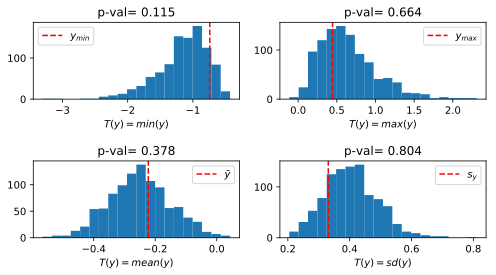

In [12]:
plt.rcParams['figure.figsize'] = 7, 4
samples = sample_posterior(1000)

plt.subplot(2, 2, 1)
p_val = np.mean(samples.min(axis=0) > y.min())
plt.hist(samples.min(axis=0), bins=20)
plt.axvline(y.min(), c='red', linestyle='--', label=r'$y_{min}$')
plt.xlabel(r'$T(y) = min(y)$')
plt.title(r'p-val= {:.3f}'.format(p_val))
plt.legend()

plt.subplot(2, 2, 2)
p_val = np.mean(samples.max(axis=0) > y.max())
plt.hist(samples.max(axis=0), bins=20)
plt.axvline(y.max(), c='red', linestyle='--', label=r'$y_{max}$')
plt.xlabel(r'$T(y) = max(y)$')
plt.title(r'p-val= {:.3f}'.format(p_val))
plt.legend()

plt.subplot(2, 2, 3)
p_val = np.mean(samples.mean(axis=0) > y.mean())
plt.hist(samples.mean(axis=0), bins=20)
plt.axvline(y.mean(), c='red', linestyle='--', label=r'$\bar{y}$')
plt.xlabel(r'$T(y) = mean(y)$')
plt.title(r'p-val= {:.3f}'.format(p_val))
plt.legend()

plt.subplot(2, 2, 4)
p_val = np.mean(samples.std(axis=0) > y.std())
plt.hist(samples.std(axis=0), bins=20)
plt.axvline(y.std(), c='red', linestyle='--', label=r'$s_y$')
plt.xlabel(r'$T(y) = sd(y)$')
plt.title(r'p-val= {:.3f}'.format(p_val))
plt.legend()

plt.tight_layout()
plt.show()

### b)

Compute the Bayesian leave-one-out cross-validation estimate of out-of-sample predictive fit

<center>$\sum^j_{j=1} log p(y_j | y_{(-j)}) = \sum^j_{j=1} log \big[\int p(y_j|\theta) p(\theta | y_{(-j)}) d\theta \big]$</center>

In [13]:
loo_likelihoods = np.zeros_like(y)

sample_size = 1000
for j, (y_j, s2_j) in enumerate(zip(y, sigma_2)):
    
    # build the leave one out dataset
    loo_y = loo(y, j)
    loo_s2 = loo(sigma_2, j)
    
    # get p(tau | y_(-j))
    tau_range = np.linspace(0, .6, 100)
    tau_posterior = np.empty_like(tau_range)
    for i, tau_star in enumerate(tau_range):
        tau_posterior[i] = compute_log_posterior(tau_star, loo_y, loo_s2)
    tau_posterior = np.exp(tau_posterior)   # take exponent and normalize
    tau_posterior = tau_posterior / tau_posterior.sum()
    
    # empty array for each loo log likelihood
    theta_sim = np.zeros(sample_size)
    
    for i in range(sample_size):
        
        # sample p(tau | y_(-j))
        tau = np.random.choice(tau_range, p=tau_posterior)
        tau += .0000001   # because tau=0 is bad

        # sample p(mu | tau, y_(-j))
        V_mu = 1. / np.sum(1. / (loo_s2 + tau**2))

        mu_hat = V_mu * np.sum(loo_y / (loo_s2 + tau**2))
        mu_sim = np.random.normal(mu_hat, np.sqrt(V_mu))
        
        # p(mu | tau, y_(-j))
        theta_sim[i] = np.random.normal(mu_sim, tau)
    
    # append log of average likelihood
    loo_likelihoods[j] = np.log(np.mean(norm.pdf(y_j, theta_sim, s2_j)))

loo_cv_score = loo_likelihoods.sum()
print('Bayesian LOO-CV estimate of out-of-sample predictive fit: {:.3f}'\
      .format(loo_cv_score))

Bayesian LOO-CV estimate of out-of-sample predictive fit: -11.773


# 3. 
Now revisit the hierarchical binomial model for the Berkeley bicycles data.

In [14]:
df = pd.read_csv('data/traffic_counts.csv')
df.T

,0,1,2,3,4,5,6,7,8,9
bicycles,16,9,10,13,19,20,18,17,35,55
others,58,90,48,57,103,57,86,112,273,64


### a) 
To test the fit of the model, examine the posterior predictive distributions of the following four test statistics: $\text{min}_j y_j$, $\text{max}_j y_j$, $\text{mean}(y_j)$, and $\text{sd}(y_j)$.

In [15]:
y_vals = df.bicycles.values
n_vals = (df.bicycles + df.others).values

def inverse_logit(x):
    return 1. / (1 + np.exp(-x))

def logit(x):
    return np.log(x / (1. - x))

def compute_posterior(a, b, y, n, use_log=False):
    log_post = -2 * np.log(a + b)
    log_post -= len(y) * np.log(beta_f(a, b))
    for y_i, n_i in zip(y_vals, n_vals):
        log_post += np.log(beta_f(a + y_i, b + n_i - y_i))
    if use_log:
        return log_post
    return np.exp(log_post)

mu = np.mean(y_vals / n_vals)
psi = mu * (1 - mu) / np.var(y_vals / n_vals, ddof=1) - 1

# define the domain
logit_mu = np.arange(-3, 0, .02)
log_psi = np.arange(0, 6, .02)

# generate the p(alpha, beta | y)
posterior_grid = np.empty((logit_mu.shape[0], log_psi.shape[0]))
for i, l_mu in enumerate(logit_mu):
    for j, l_psi in enumerate(log_psi):
        mu = inverse_logit(l_mu)
        psi = np.exp(l_psi)
        alpha = mu * psi
        beta = (1 - mu) * psi
        posterior_grid[i,j] = np.nan_to_num(np.log(alpha)) + np.nan_to_num(np.log(beta)) + \
                              compute_posterior(alpha, beta, y_vals, n_vals, True)

In [16]:
def sample_bikes_posterior(n):
    prob_grid = posterior_grid / posterior_grid.sum()   # normalized
    mu_prob_marg = prob_grid.sum(axis=1)
    
    # we need the index to get the marginal for each beta
    mu_samples_ind = np.random.choice(list(range(logit_mu.shape[0])), n, replace=True, p=mu_prob_marg)
    mu_samples = logit_mu[mu_samples_ind]

    psi_samples = np.empty_like(mu_samples)
    
    # sample the transformed prior
    for i, sample_ind in enumerate(mu_samples_ind):
        probs = posterior_grid[sample_ind] / posterior_grid[sample_ind].sum()
        psi_star = np.random.choice(log_psi, 1, replace=True, p=probs)
        psi_samples[i] = psi_star
        
    # convert the prior samples back, draw from beta distribution
    mu_sim = np.array([inverse_logit(x) for x in mu_samples])
    psi_sim = np.exp(psi_samples)
    alpha_sim = mu_sim * psi_sim
    beta_sim = (1 - mu_sim) * psi_sim
    
    # sample posterior with sampled prior
    samples = []
    for a, b in zip(alpha_sim, beta_sim):
        samples.append(np.random.beta(a + y_vals, b + n_vals - y_vals))
        
    return np.array(samples).T

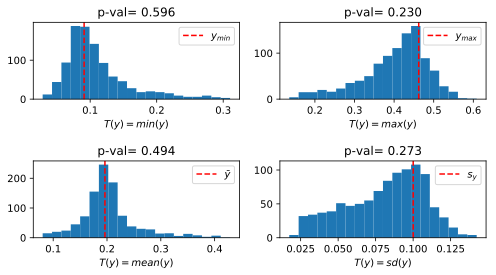

In [19]:
samples = sample_bikes_posterior(1000)
y = y_vals / n_vals

plt.subplot(2, 2, 1)
p_val = np.mean(samples.min(axis=0) > y.min())
plt.hist(samples.min(axis=0), bins=20)
plt.axvline(y.min(), c='red', linestyle='--', label=r'$y_{min}$')
plt.xlabel(r'$T(y) = min(y)$')
plt.title(r'p-val= {:.3f}'.format(p_val))
plt.legend()

plt.subplot(2, 2, 2)
p_val = np.mean(samples.max(axis=0) > y.max())
plt.hist(samples.max(axis=0), bins=20)
plt.axvline(y.max(), c='red', linestyle='--', label=r'$y_{max}$')
plt.xlabel(r'$T(y) = max(y)$')
plt.title(r'p-val= {:.3f}'.format(p_val))
plt.legend()

plt.subplot(2, 2, 3)
p_val = np.mean(samples.mean(axis=0) > y.mean())
plt.hist(samples.mean(axis=0), bins=20)
plt.axvline(y.mean(), c='red', linestyle='--', label=r'$\bar{y}$')
plt.xlabel(r'$T(y) = mean(y)$')
plt.title(r'p-val= {:.3f}'.format(p_val))
plt.legend()

plt.subplot(2, 2, 4)
p_val = np.mean(samples.std(axis=0) > y.std())
plt.hist(samples.std(axis=0), bins=20)
plt.axvline(y.std(), c='red', linestyle='--', label=r'$s_y$')
plt.xlabel(r'$T(y) = sd(y)$')
plt.title(r'p-val= {:.3f}'.format(p_val))
plt.legend()

plt.tight_layout()
plt.show()

### b)
Compute the Bayesian leave-one-out cross-validation estimate of out-of-sample predictive fit.

In [423]:
sample_size = 1000

loo_likelihoods = np.zeros_like(y_vals).astype(float)
for j, (y_j, n_j) in enumerate(zip(y_vals, n_vals)):
    
    # build the leave one out dataset
    loo_y = loo(y_vals, j)
    loo_n = loo(n_vals, j)
    
    # build the loo posterior
    mu = np.mean(loo_y / loo_n)
    psi = mu * (1 - mu) / np.var(loo_y / loo_n, ddof=1) - 1
    logit_mu = np.arange(-3, 0, .02)
    log_psi = np.arange(0, 6, .02)

    posterior_grid = np.empty((logit_mu.shape[0], log_psi.shape[0]))
    for i, l_mu in enumerate(logit_mu):
        for k, l_psi in enumerate(log_psi):
            mu = inverse_logit(l_mu)
            psi = np.exp(l_psi)
            alpha = mu * psi
            beta = (1 - mu) * psi
            posterior_grid[i,k] = np.nan_to_num(np.log(alpha)) + np.nan_to_num(np.log(beta)) + \
                                  compute_posterior(alpha, beta, loo_y, loo_n, True)

    # sample p(alpha, beta | y)
    prob_grid = posterior_grid / posterior_grid.sum()   # normalized
    mu_prob_marg = prob_grid.sum(axis=1)
    
    # we need the index to get the marginal for each beta
    mu_samples_ind = np.random.choice(list(range(logit_mu.shape[0])), sample_size,
                                      replace=True, p=mu_prob_marg)
    mu_samples = logit_mu[mu_samples_ind]

    psi_samples = np.empty_like(mu_samples)
    
    # sample the transformed prior
    for i, sample_ind in enumerate(mu_samples_ind):
        probs = posterior_grid[sample_ind] / posterior_grid[sample_ind].sum()
        psi_star = np.random.choice(log_psi, 1, replace=True, p=probs)
        psi_samples[i] = psi_star
        
    # convert the prior samples back, draw theta_j_sim from beta distribution
    mu_sim = np.array([inverse_logit(x) for x in mu_samples])
    psi_sim = np.exp(psi_samples)
    alpha_sim = mu_sim * psi_sim
    beta_sim = (1 - mu_sim) * psi_sim
    
    # append the loo likelihood
    loo_likelihoods[j] = np.log(np.mean(scipy_beta.pdf(float(y_j) / n_j, alpha_sim + y_j,
                                        beta_sim + n_j - y_j)))
    
loo_cv_score = loo_likelihoods.sum()
print('Bayesian LOO-CV estimate of out-of-sample predictive fit: {:.3f}'\
      .format(loo_cv_score))

Bayesian LOO-CV estimate of out-of-sample predictive fit: 20.447


# 4.
4. A simple random sample of size n = 30 is taken from a population of size N = 450, the observed values (you can copy and paste this into <s>R</s> Python) are

`
y.obs <- c(80, 76, 83, 78, 81, 77, 81, 83, 82, 84, 87, 74, 75, 80, 79, 79, 80, 78, 76, 77, 84, 78, 79, 76, 79, 75, 84, 78, 81, 76)
`

Give a 95% posterior interval for the population mean.

Suggestion: Assume the finite-population $y = (y_1,..., y_N)$ are a random sample from a
superpopulation that is $\text{Normal}(\mu, \sigma^2)$, with the noninformative prior $p(\mu, \sigma^2) \propto (\sigma^2)^{-1}$;
our interest is in $p(\bar{y} | y_{{ons}})$ for the finite-population mean $\bar{y} = \frac{n}{N} \bar{y}_{\text{obs}} + \frac{N-n}{N} \bar{y}_{\text{mis}}$.

In [424]:
y_obs = np.array([80, 76, 83, 78, 81, 77, 
                  81, 83, 82, 84, 87, 74, 
                  75, 80, 79, 79, 80, 78, 
                  76, 77, 84, 78, 79, 76, 
                  79, 75, 84, 78, 81, 76])

n = y_obs.shape[0]
N = 450

95% posterior interval for y_bar [78.24, 80.52]


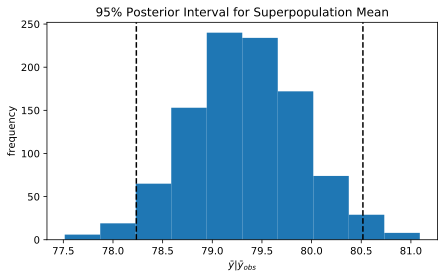

In [428]:
sample_size = 1000

# generate s^2 samples
w_sim = np.random.chisquare(n - 1, sample_size)
sample_var_sim = (n-1) * y_obs.var() / w_sim

# generate mu samples
mu_sim = np.random.normal(y_obs.mean(), (sample_var_sim / n)**.5)

# generate missing y-bars
y_mis_sim = np.random.normal(mu_sim, (sample_var_sim / (N - n))**.5)
y_bar_sim = (n / N) * y_obs.mean() + ((N - n) / N) * y_mis_sim

lower, upper = np.percentile(y_bar_sim, [2.5, 97.5])
print('95% posterior interval for y_bar [{:.2f}, {:.2f}]'.format(lower, upper))

# plot it
plt.rcParams['figure.figsize'] = 7, 4
plt.hist(y_bar_sim)
plt.axvline(lower, color='black', linestyle='--')
plt.axvline(upper, color='black', linestyle='--')
plt.xlabel(r'$\bar{y} | \bar{y}_{obs}$')
plt.ylabel('frequency')
plt.title('95% Posterior Interval for Superpopulation Mean')
plt.show()

# 5. 
A university has 807 faculty members. A frequency table for number of refereed publications is given below for a simple random sample of 50 faculty members.

In [429]:
pubs = pd.read_csv('data/publications.csv')
pubs.T

,0,1,2,3,4,5,6,7,8,9,10
n_pubs,0,1,2,3,4,5,6,7,8,9,10
n_faculty,28,4,3,4,4,2,1,0,2,1,1


In [430]:
N = 807
n = pubs['n_faculty'].sum()

# load up the raw numbers
data = []
for p, f in pubs[['n_pubs', 'n_faculty']].values:
    for _ in range(f):
        data.append(p)
data = np.array(data)

95% posterior interval [1169, 1741]


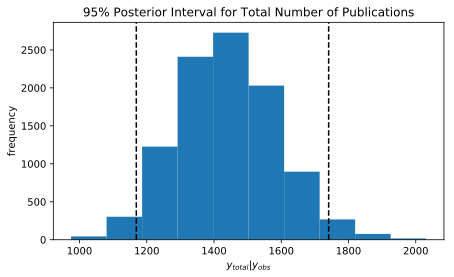

In [439]:
sample_size = 10000


alpha = data.sum()   # sum of number of pubs
beta = 1. /len(data)   # n faculty members observed

obs_total = data.sum().astype(int)

total_pubs_sim = np.zeros(sample_size)
for s in range(sample_size):
    # generate theta samples (mean and variance)
    theta_sim = np.random.gamma(alpha, beta)
    # simulate missing data using theta_sim
    total_pubs_sim[s] = np.random.poisson(theta_sim, N - n).sum() + obs_total

lower, upper = np.percentile(total_pubs_sim, [2.5, 97.5]).astype(int)
print('95% posterior interval [{}, {}]'.format(lower, upper))

# plot it
plt.hist(total_pubs_sim)
plt.axvline(lower, color='black', linestyle='--')
plt.axvline(upper, color='black', linestyle='--')
plt.xlabel(r'$y_{total} | y_{obs}$')
plt.ylabel('frequency')
plt.title('95% Posterior Interval for Total Number of Publications')
plt.show()

# 6.
Consider an agricultural experiment to compare three varieties of oats. Each of the four plots of land that constitute the growing area is subdivided into three subplots, and each variety was sown at exactly one (randomly selected) subplot within each plot. The yield in ‘grams per row’ was recorded.

In [440]:
df_oats = pd.DataFrame({
    'block': [1, 2, 3, 4],
    'A': [330, 288, 295, 313],
    'B': [372, 340, 343, 341],
    'C': [359, 337, 373, 302]
}).set_index('block')
df_oats

,A,B,C
block,,,
1,330,372,359
2,288,340,337
3,295,343,373
4,313,341,302


This is a randomized blocks design in which *oat variety* is the treatment, and *plot of land* is the blocking variable. The *subplots* are the experimental units.

### a)
Express this experiment in the general notation of Section 8.2 of Gelman et al, specifying $x$, $y_{obs}$, $y_{mis}$, $N$, and $I$. How many observed responses and how many unobserved responses are there?
<hr>
$p(\theta\ |\ x, y_{obs}, I) \propto p(\theta) \int\int p(\phi | x, \theta) p(y | x, \theta) p(I | x, y, \phi) dy_{mis}d\phi$

There are 12 observed responses and 24 unobserved responses

### b)
Under the randomized blocks design, what is the distribution of I? Is the missing data mechanism ignorable? Strongly ignorable? Are the propensity scores an adequate summary?
<hr>
Thought the study applies each treatment to each subplot, there are still interactions we are not observing. Each subplot is a plot in and of itself and we can only apply one treatment to it. Looking at the subplots as the experimental units, we can write $I$ as follows:

In [441]:
I = np.zeros((12, 3)).astype(int)
for i in range(I.shape[0]):
    for j in range(I.shape[1]):
        if i % 3 == j:
            I[i, j] = 1 
ind = [block + 1 + subplot for block in range(4)
                           for subplot in [.1, .2, .3]]
df_I = pd.DataFrame(data=I, columns=['A', 'B', 'C'], index=ind)
df_I

,A,B,C
1.1,1,0,0
1.2,0,1,0
1.3,0,0,1
2.1,1,0,0
2.2,0,1,0
2.3,0,0,1
3.1,1,0,0
3.2,0,1,0
3.3,0,0,1
4.1,1,0,0


By looking at the obvious pattern in the missing observations, we can see that the data is not missing at random. For each subplot there can only be a single treatment applied. In turn, the value of any element in $I$ depends on the other members of that row, as each row must sum to 1. 

This is deterministics and a function of covariates that we can fully observe. As a result it is *strongly ignorable*.